# **`A. Importation des bibliothèques utiles et paramètrages`**
------

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, make_scorer, recall_score, precision_score, confusion_matrix, classification_report

In [3]:
# Setup du nombre de lignes et colonnes maximum
pd.set_option('display.max_row',100)
pd.set_option('display.max_columns',34)

# Filtre des avertissements
warnings.filterwarnings('ignore')

# Style et taille de nos figures
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

# Fixer le générateur
np.random.seed(42)

# **`B. Chargement de la base de données et copie`**
------

In [4]:
# Chargement de la base de données
data = pd.read_csv("./DRUG1n.csv")

In [5]:
# Copie de la base de données
df = data.copy()

# **`C. Analyse Exploratoire des données`**
------

> ## **1. Analyse de forme** 

- **Dimensions** : Nous disposons d'une base de **200 observations** et **7 variables**.

- **Type de variables** : **3 quantitatives** et **4 qualitatives**.

- **Target named `Drug`** : Variable qualitative.

     * **drugY** : **45.5%**
     * **drugX** : **27.0%**
     * **drugA** : **11.5%**
     * **drugB** : **8.8%**
     * **drugC** : **8.8%**
     
- **NB** : Etant donné une variable cible déséquilibrée, nous utiliserons comme métrique le **f1_score**. Nous nous intéresserons aussi à la **précision**, le **rappel** et la **matrice de confusion**.

- **Données Manquantes** : Notre base de données ne contient pas de données manquantes.

- **Données dupliquées** : Notre base ne contient pas de données dupliquées.

In [6]:
#Apperçu de la base de données
df.head(10)

,Age,Sex,BP,Cholesterol,Na,K,Drug
0,23,F,HIGH,HIGH,0.792535,0.031258,drugY
1,47,M,LOW,HIGH,0.739309,0.056468,drugC
2,47,M,LOW,HIGH,0.697269,0.068944,drugC
3,28,F,NORMAL,HIGH,0.563682,0.072289,drugX
4,61,F,LOW,HIGH,0.559294,0.030998,drugY
5,22,F,NORMAL,HIGH,0.676901,0.078647,drugX
6,49,F,NORMAL,HIGH,0.789637,0.048518,drugY
7,41,M,LOW,HIGH,0.766635,0.069461,drugC
8,60,M,NORMAL,HIGH,0.777205,0.051230,drugY
9,43,M,LOW,NORMAL,0.526102,0.027164,drugY


In [7]:
#Dimensions de la base de données
df.shape

(200, 7)

In [8]:
#Type des variables
df.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na             float64
K              float64
Drug            object
dtype: object

In [9]:
# Nombre de variables quantitatives et qualitatives
df.dtypes.value_counts()

object     4
float64    2
int64      1
dtype: int64

In [10]:
# Nombre de modalités de la target
df['Drug'].unique()

array(['drugY', 'drugC', 'drugX', 'drugA', 'drugB'], dtype=object)

In [11]:
# Fréquence des modalités de la target
df['Drug'].value_counts()

drugY    91
drugX    54
drugA    23
drugB    16
drugC    16
Name: Drug, dtype: int64

In [12]:
# Proportion des modalités de la target
df['Drug'].value_counts(normalize = True)*100

drugY    45.5
drugX    27.0
drugA    11.5
drugB     8.0
drugC     8.0
Name: Drug, dtype: float64

<AxesSubplot:>

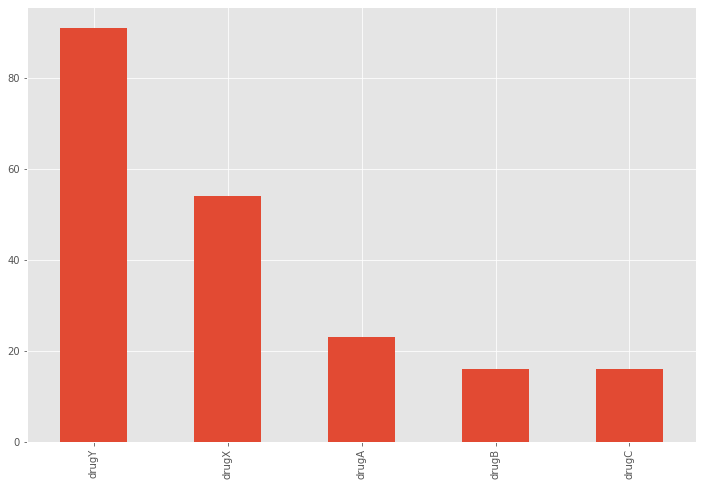

In [13]:
df["Drug"].value_counts().plot.bar()

In [14]:
# Analyse des données manquantes par rapport à chaque variable
df.isnull().sum(axis = 0)

Age            0
Sex            0
BP             0
Cholesterol    0
Na             0
K              0
Drug           0
dtype: int64

In [15]:
# Nombre de valeurs uniques que prennent les variables
for i in df.columns.tolist():
    print("{} : {} \n".format(i,df[i].nunique()))

Age : 57 

Sex : 2 

BP : 3 

Cholesterol : 2 

Na : 200 

K : 200 

Drug : 5 



In [16]:
# Analyse des données dupliquées
df.duplicated().sum()

0

> ## **2. Analyse de fond** 

>> ### **2.1. Variables numériques** 

In [17]:
# Type des variables
df.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na             float64
K              float64
Drug            object
dtype: object

In [18]:
# Selection des variables numériques
num_cols = [i for i in df.select_dtypes(exclude = 'object').columns.tolist()]
num_cols

['Age', 'Na', 'K']

In [19]:
# Nombre de valeurs uniques
df[num_cols].nunique()

Age     57
Na     200
K      200
dtype: int64

In [20]:
# Statistique descriptive
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,44.315000,16.544315,15.000000,31.000000,45.000000,58.000000,74.000000
Na,200.0,0.697095,0.118907,0.500169,0.583887,0.721853,0.801494,0.896056
K,200.0,0.050174,0.017611,0.020022,0.035054,0.049663,0.066000,0.079788


<AxesSubplot:>

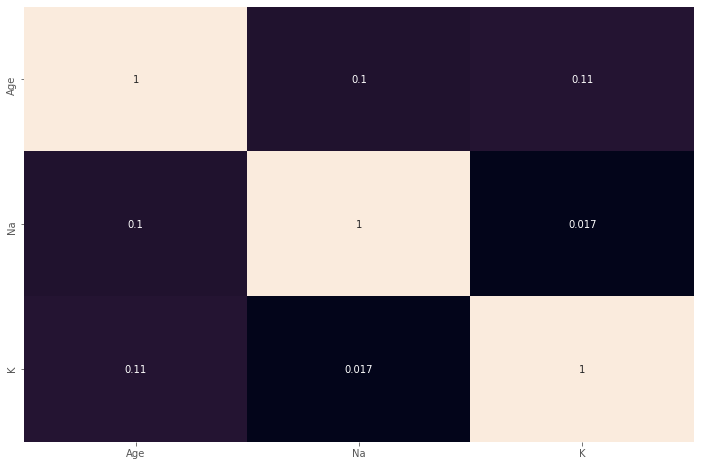

In [21]:
# Corrélations entre variables numériques ou quantitatives
sns.heatmap(df[num_cols].corr(), cbar = False, annot = True)

**Il faut intérpréter tes résultats**

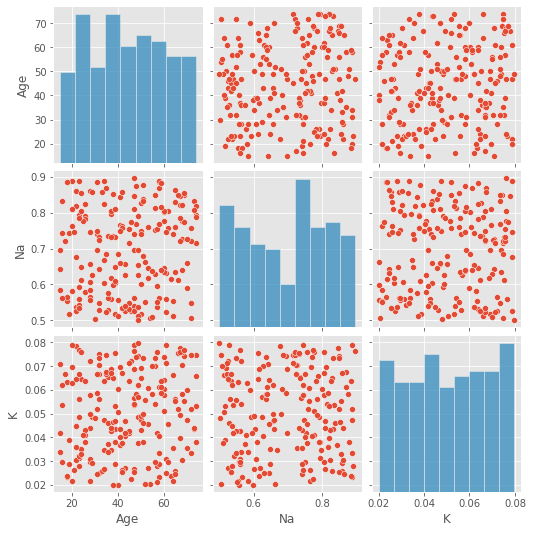

In [22]:
# Vue globale (nuage de points et histogrammes)
sns.pairplot(df[num_cols])

**Que nous apprend ces figures ci-dessus**

- Un test statistique est une procédure de décision entre deux hypothèses. Il s’agit d’une démarche consistant à rejeter ou à ne pas rejeter une hypothèse statistique, appelée hypothèse nulle $H_{0}$, en fonction d’un jeu de données.

- Il existe un test pour déterminer si deux variables continues (quantitatives) sont indépendantes : **le test de corrélation de Pearson**. L’hypothèse nulle à tester est : **« les deux variables testées sont indépendantes »**.

- Il s’accompagne d’une statistique de test et d’une p-valeur qui détermine du rejet ou non de l’hypothèse nulle.

- Si la **p-value** est inférieur à **5%** alors on rejette l'hypothèse nulle $H_{0}$, sinon on l'accepte.

In [23]:
# Définition d'une fonction de test entre variables quantitatives
def test_pearson(df, var1, var2):
    print("{} et {}".format(var1,var2))
    print("Coefficient de Pearson : {}".format(pearsonr(df[var1],df[var2])[0]))
    print("               P_value : {}".format(pearsonr(df[var1],df[var2])[1]))
    if (pearsonr(df[var1],df[var2])[1] < 0.05):
        print("{} et {} ne sont pas indépendantes".format(var1,var2))
    print("\n \n")
    pass

In [24]:
# Test Statistique de Pearson
from scipy.stats import pearsonr
liste = []
for var1 in num_cols:
    liste.append(var1)
    for var2 in [var for var in num_cols if var not in liste ]:
        test_pearson(df,var1,var2)

Age et Na
Coefficient de Pearson : 0.10037117622299319
               P_value : 0.15732104241114084

 

Age et K
Coefficient de Pearson : 0.1114912374476258
               P_value : 0.1160096074509135

 

Na et K
Coefficient de Pearson : 0.017334587466501242
               P_value : 0.8075175505627852

 



- Age et Na ne sont pas indépendantes
- Age et K ne sont pas indépendantes
- Na et K ne sont pas  indépendantes

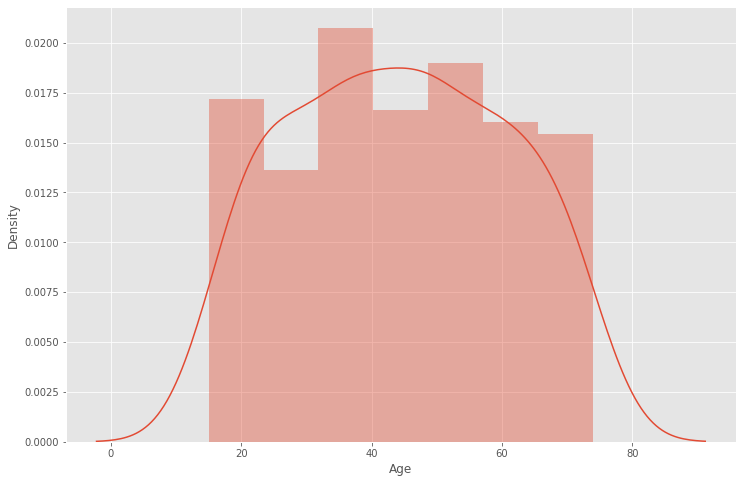

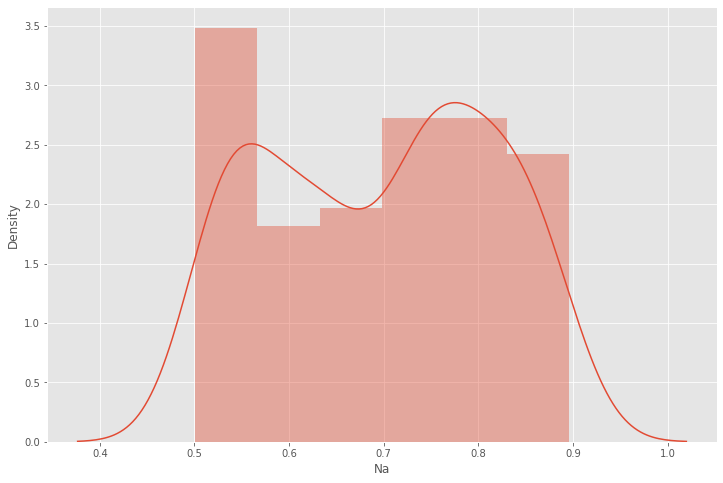

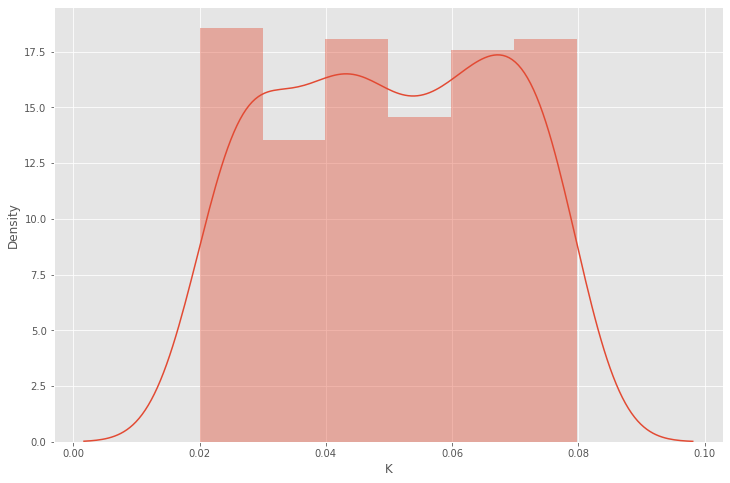

In [25]:
# Distribution des variables numériques
for i in num_cols:
    plt.figure(figsize = (12,8))
    sns.distplot(df[i])
    plt.show()

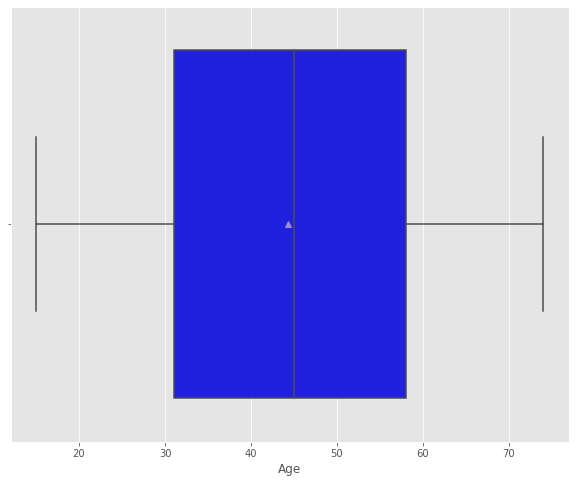

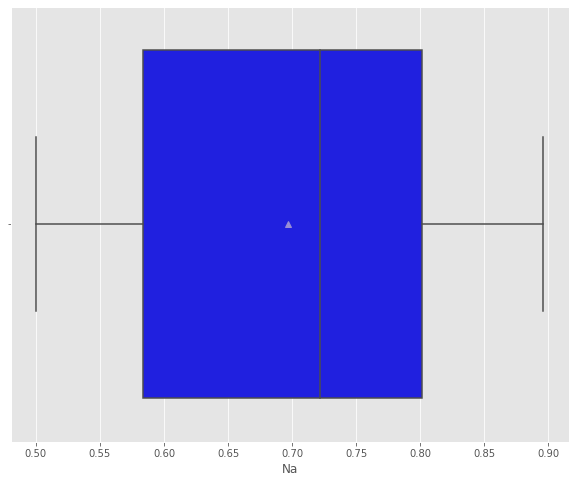

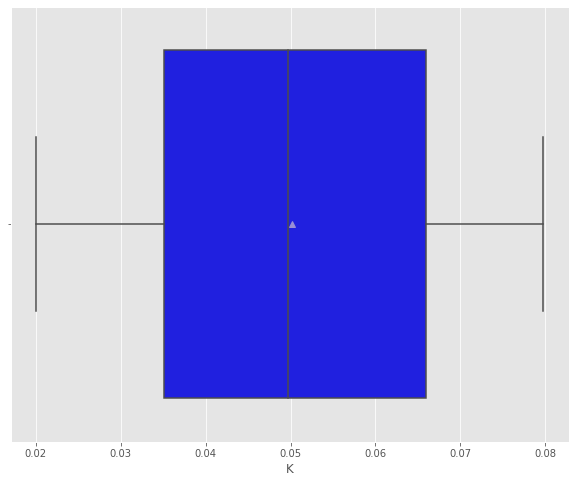

In [26]:
# Analyse des données aberrantes
for i in num_cols:
    plt.figure(figsize = (10,8))
    sns.boxplot(df[i],showmeans = True, color = 'blue')
    plt.show()

>> ### **2.2. Variables qualitatives** 

In [27]:
#Type des variables de la base de données
df.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na             float64
K              float64
Drug            object
dtype: object

In [28]:
#Sélection de variables qualitatives
qual_cols = num_cols = [i for i in df.select_dtypes(include = 'object').columns.tolist()
                        if i not in ['Drug']]
qual_cols

['Sex', 'BP', 'Cholesterol']

In [29]:
# Nombre de modalités uniques pour chaque variable qualitative
df[qual_cols].nunique()

Sex            2
BP             3
Cholesterol    2
dtype: int64

In [30]:
# Modalités uniques des variables qualitatives
for var in qual_cols:
    print("{} : {} \n".format(var, df[var].unique().tolist()))

Sex : ['F', 'M'] 

BP : ['HIGH', 'LOW', 'NORMAL'] 

Cholesterol : ['HIGH', 'NORMAL'] 



In [31]:
#Statistique descriptives
df[qual_cols].describe().T

,count,unique,top,freq
Sex,200,2,M,104
BP,200,3,HIGH,77
Cholesterol,200,2,HIGH,103


array([<AxesSubplot:ylabel='freq'>], dtype=object)

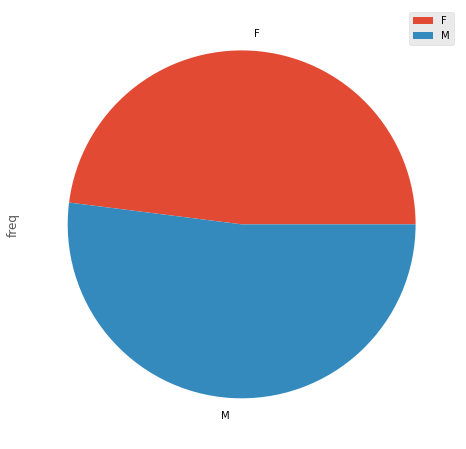

In [32]:
sex = pd.crosstab(df.Sex, "freq")
sex.plot.pie(subplots=True)

Pour savoir si deux variables catégorielles sont liées, on utilise le célèbre test du khi-deux. Dans ce dernier, l’hypothèse nulle est simplement **« les deux variables testées sont indépendantes »**. Si la p-value de test obtenue est en-dessous de **5%** alors **on rejette l’hypothèse nulle**.

En Python le test est facilement implémentable à l’aide de la bibliothèque **scipy** et de sa fonction **chi2_contingency**. Elle permet d’obtenir rapidement la **p-valeur** du test ainsi que la **statistique** et le **degré de liberté** associé. Dans la pratique le test du khi-deux demande, en amont, un petit travail sur les données. Pour pouvoir effectuer le test il faut d’abord déterminer la **table de contingence**. C’est un tableau de croisement entre les modalités des deux variables. Il s’obtient facilement avec la fonction crosstab de Pandas.

In [33]:
# Définition d'une fonction de test entre variables qualitatives
def test_khi2(df, var1, var2):
    table = pd.crosstab(df[var1],df[var2])
    resultats = chi2_contingency(table)
    print("{} et {}".format(var1,var2))
    print("Statistique de test : {}".format(resultats[0]))
    print("   Degré de liberté : {}".format(resultats[2]))
    print("            P_value : {}".format(resultats[1]))
    if ( resultats[1] < 0.05):
        print("{} et {} ne sont pas indépendantes".format(var1,var2))
    print("\n \n")
    pass

In [34]:
#Test Statistique du Khi-deux
from scipy.stats import chi2_contingency
liste = []
for var1 in qual_cols:
    liste.append(var1)
    for var2 in [var for var in qual_cols if var not in liste ]:
        test_khi2(df,var1,var2)

Sex et BP
Statistique de test : 0.7110738837433747
   Degré de liberté : 2
            P_value : 0.7007970548859668

 

Sex et Cholesterol
Statistique de test : 0.0002887213877104998
   Degré de liberté : 1
            P_value : 0.986443154652954

 

BP et Cholesterol
Statistique de test : 4.33632565148387
   Degré de liberté : 2
            P_value : 0.11438757389420079

 



- Sex et BP sont indépendantes
- Sex et Cholesterol sont indépendantes
- BP et Cholesterol sont indépendantes

**NB :** Vous pouvez pousser l'analyse beaucoup plus loin en étudiant la relation entre variables numériques et qualitatives, entre variables explicative et à expliquer...

In [35]:
pd.crosstab(df.Sex, df.Cholesterol)

Cholesterol,HIGH,NORMAL
Sex,,
F,49,47
M,54,50


In [36]:
pd.crosstab(df.BP, df.Drug)

Drug,drugA,drugB,drugC,drugX,drugY
BP,,,,,
HIGH,23,16,0,0,38
LOW,0,0,16,18,30
NORMAL,0,0,0,36,23


In [37]:
pd.crosstab(df.Sex, df.Drug)

Drug,drugA,drugB,drugC,drugX,drugY
Sex,,,,,
F,9,6,7,27,47
M,14,10,9,27,44


<AxesSubplot:xlabel='Cholesterol'>

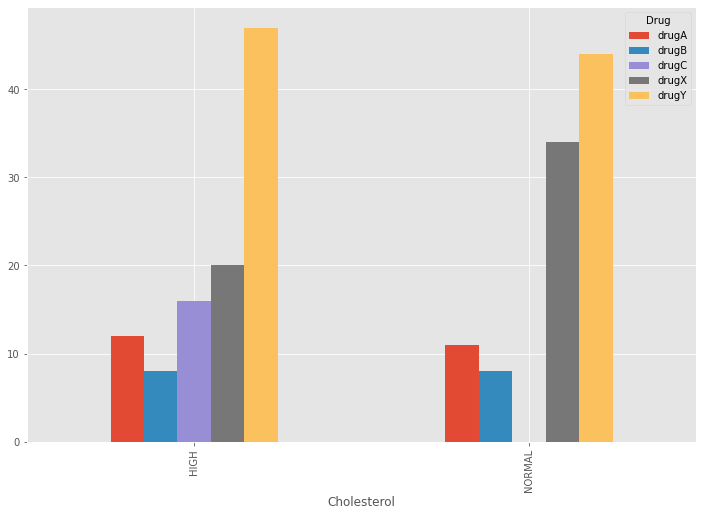

In [38]:
t = pd.crosstab(df.Cholesterol, df.Drug)
t.plot.bar()

Pour les patients dont leur *`cholesterol`* est normal, le *`DrugC`* ne leur sont pas prescrit.

>> ### **2.3. Analyse multivariée** 

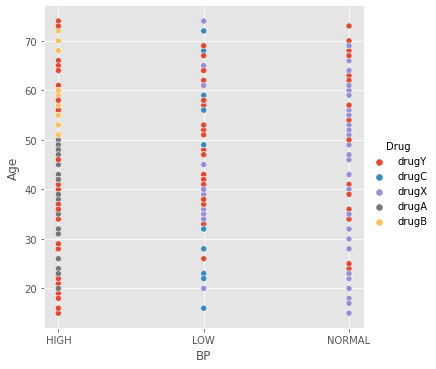

In [39]:
sns.relplot(x="BP", y="Age", hue="Drug",
            data=df)

Dans cette partie, nous analysons les corrélations entre la variable cible Drug et les variables explicatives Na et K. En d’autres termes, nous aimerions savoir entre autres si:

*   le médicament à préscrire dépend de Na ou K

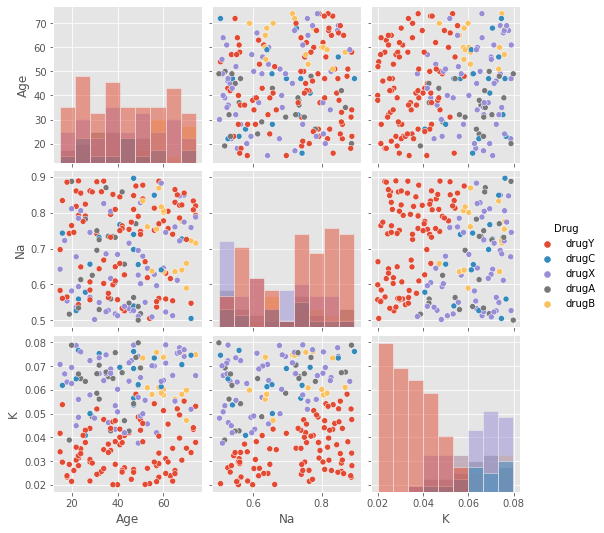

In [40]:
# Vue globale (nuage de points et histogrammes)
# variable_num = ['Age', 'Na','K']
sns.pairplot(df, hue='Drug', diag_kind='hist')

Le nuage de points ci-dessus, nous montre que les points rouges sont séparés clairement des autres, ce qui illustre que le médicament Y est donné si le ratio `Na/K` ou `K/Na` est supérieur ou inférieur à un seuil. Par conséquent, la variable Na/k doit être crées car elle explique mieux la variable Drug que les variables `Na` et `K` prises séparemment.

# **`D. Objectifs & Métriques`**
------

> ## **1. Objectif** 

Développer un modèle performant de classification pour prédire le Drug.

> ## **2. Métrique** 

Etant donné une variable cible déséquilibrée, nous choisirons comme métriques le F1_score, la Precision et le Rappel.

# **`E. Prétraitement`**
------

In [41]:
# Nouvelle copie de la base de données
df = data.copy()

In [42]:
# Apperçu de notre dataset
df.head()

,Age,Sex,BP,Cholesterol,Na,K,Drug
0,23,F,HIGH,HIGH,0.792535,0.031258,drugY
1,47,M,LOW,HIGH,0.739309,0.056468,drugC
2,47,M,LOW,HIGH,0.697269,0.068944,drugC
3,28,F,NORMAL,HIGH,0.563682,0.072289,drugX
4,61,F,LOW,HIGH,0.559294,0.030998,drugY


> ## **1. Selection de variables indépendantes/explicatives**

>> ### **1.1. Variables qualitatives** 

La variable cible est qualitative. Ainsi, pour étudier la relation entre elle et les variables qualitatives nous ferons un test de khi-deux.

In [43]:
# Définition d'une fonction de test entre variables qualitatives
def test_khi2(df, var1, var2):
    table = pd.crosstab(df[var1],df[var2])
    resultats = chi2_contingency(table)
    print("{} et {}".format(var1,var2))
    print("Statistique de test : {}".format(resultats[0]))
    print("   Degré de liberté : {}".format(resultats[2]))
    print("            P_value : {}".format(resultats[1]))
    if ( resultats[1] < 0.05):
        print("{} et {} ne sont pas indépendantes".format(var1,var2))
    print("\n \n")
    pass

In [44]:
#Test Statistique du Khi-deux
from scipy.stats import chi2_contingency
liste = []
for var1 in qual_cols:
    liste.append(var1)
    for var2 in [var for var in qual_cols if var not in liste ]:
        test_khi2(df,var1,var2)

Sex et BP
Statistique de test : 0.7110738837433747
   Degré de liberté : 2
            P_value : 0.7007970548859668

 

Sex et Cholesterol
Statistique de test : 0.0002887213877104998
   Degré de liberté : 1
            P_value : 0.986443154652954

 

BP et Cholesterol
Statistique de test : 4.33632565148387
   Degré de liberté : 2
            P_value : 0.11438757389420079

 



In [45]:
#Test Statistique du Khi-deux
from scipy.stats import chi2_contingency
for var1 in ['Cholesterol', 'BP', 'Sex']:
    test_khi2(df,var1,'Drug')

Cholesterol et Drug
Statistique de test : 19.609657681313468
   Degré de liberté : 4
            P_value : 0.0005962588389856516
Cholesterol et Drug ne sont pas indépendantes

 

BP et Drug
Statistique de test : 143.23287184969993
   Degré de liberté : 8
            P_value : 5.041733414466518e-27
BP et Drug ne sont pas indépendantes

 

Sex et Drug
Statistique de test : 2.119248418109203
   Degré de liberté : 4
            P_value : 0.7138369773987128

 



> ### **2. Création d'une nouvelle variable calculée** 

In [46]:
#Création d'un champ calculé Na_sur_K
df['Na_sur_K']=df['Na']/df['K']
df.head()

,Age,Sex,BP,Cholesterol,Na,K,Drug,Na_sur_K
0,23,F,HIGH,HIGH,0.792535,0.031258,drugY,25.354629
1,47,M,LOW,HIGH,0.739309,0.056468,drugC,13.092530
2,47,M,LOW,HIGH,0.697269,0.068944,drugC,10.113556
3,28,F,NORMAL,HIGH,0.563682,0.072289,drugX,7.797618
4,61,F,LOW,HIGH,0.559294,0.030998,drugY,18.042906


In [47]:
# test d'indépendence entre les variables K et Na_sur_K
test_pearson(df, 'K', 'Na_sur_K')
# test d'indépendence entre les variables Na et Na_sur_K
test_pearson(df, 'Na', 'Na_sur_K')

K et Na_sur_K
Coefficient de Pearson : -0.8683725306633279
               P_value : 3.190348978295469e-62
K et Na_sur_K ne sont pas indépendantes

 

Na et Na_sur_K
Coefficient de Pearson : 0.35073033169239526
               P_value : 3.549448324091684e-07
Na et Na_sur_K ne sont pas indépendantes

 



Puisque les variables `Na` et `K` sont liées à la variable `Na_sur_K`, nous allons seulement retenir `Na_sur_K` (et non plus Na et K) comme potentiel descipteur de la variable cible.

> ## **3. Encodage des variables qualitatives**

In [48]:
#Selections des variables qualitatives
qual_cols = num_cols = [i for i in df.select_dtypes(include = 'object').columns.tolist()]
qual_cols

['Sex', 'BP', 'Cholesterol', 'Drug']

In [49]:
#Modalités uniques
for var in qual_cols:
    print("{} : {} \n".format(var, df[var].unique().tolist()))

Sex : ['F', 'M'] 

BP : ['HIGH', 'LOW', 'NORMAL'] 

Cholesterol : ['HIGH', 'NORMAL'] 

Drug : ['drugY', 'drugC', 'drugX', 'drugA', 'drugB'] 



>>>  **Rappel**
- Les variables qualitatives ne sont pas encodées. Comme certains des algorithmes de Machine Learning ne peuvent pas apprendre avec des données qualitatives, nous penserons à les encoder comme suit : 

    * Un **`encodage oneHot`** pour les variables catégorielles nominales.

    * Un **`encodage ordinal`** pour les variables catégorielles ordinales. Exemple : **`Cholesterol`** qui a comme modalités **`High, Normal, Low`** où **`Low < Normal < High`**

In [50]:
#Cette fonction permet de remplacer les modalités d'une variable par leur valeur numérique correspondante définie dans la fonction replace.
#Exemple :
#   M : 1
#   F : 0
def manual_encoder(df):
    df['Sex'] = df['Sex'].replace(['M', 'F'],[1,0])
    df['BP'] = df['BP'].replace(['HIGH', 'LOW', 'NORMAL'],[3,2,1])
    df['Cholesterol'] = df['Cholesterol'].replace(['HIGH', 'NORMAL'],[3,1])
    df['Drug'] = df['Drug'].replace(['drugY', 'drugX', 'drugA', 'drugB','drugC'],[0,2,1,3,4])
    return df

In [51]:
# Encodage des variables
df_new = manual_encoder(df)

In [52]:
# Selection des variables
variables = ['Age','Sex','BP','Cholesterol','Na_sur_K','Drug']
df_new = df[variables]
df_new.head()

,Age,Sex,BP,Cholesterol,Na_sur_K,Drug
0,23,0,3,3,25.354629,0
1,47,1,2,3,13.092530,4
2,47,1,2,3,10.113556,4
3,28,0,1,3,7.797618,2
4,61,0,2,3,18.042906,0


In [53]:
#dimensions de la nouvelle base encodée
df_new.shape

(200, 6)

Notre nouvelle base contient maintent 6 variables pour 200 observations.

> ## **4. Division de la base en Train / Test**

In [54]:
df_new['Drug'].value_counts(normalize = True)*100

0    45.5
2    27.0
1    11.5
4     8.0
3     8.0
Name: Drug, dtype: float64

In [55]:
# Affectation de la matrice de variables explicatives à X et de la target à y
X = df_new.drop('Drug', axis = 1)
y = df_new[['Drug']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)

In [56]:
print("Dimensions X_train :", X_train.shape)
print("Dimensions y_train :", y_train.shape)
print("Dimensions X_test :", X_test.shape)
print("Dimensions y_test :", y_test.shape)

Dimensions X_train : (160, 5)
Dimensions y_train : (160, 1)
Dimensions X_test : (40, 5)
Dimensions y_test : (40, 1)


In [57]:
y_test.value_counts(normalize = True)*100

Drug
0       45.0
2       27.5
1       12.5
4        7.5
3        7.5
dtype: float64

In [58]:
y_train.value_counts(normalize = True)*100

Drug
0       45.625
2       26.875
1       11.250
4        8.125
3        8.125
dtype: float64

# **`F. Modélisation`**
------

> ## **1. Premier Essai**

In [59]:
#Définition de fonction 
def modelisation(Models, X_scaled_train , Y_train, X_scaled_test, Y_test):
    scores = []
    for model in Models:
        mod = model()
        debut = time.time()
        mod.fit(X_scaled_train,Y_train)
        fin = time.time()
        y_pred_test = mod.predict(X_scaled_test)
        y_pred_train = mod.predict(X_scaled_train)
        scores.append({
                    "Modele":type(mod).__name__,  
                    "F1_score_train": f1_score(Y_train,y_pred_train, average='micro'), 
                    "Recall_train": recall_score(Y_train,y_pred_train, average='micro'),
                    "Precision_train": precision_score(Y_train,y_pred_train, average='micro'),
                    "F1_score_test": f1_score(Y_test,y_pred_test, average='micro'), 
                    "Recall_test": recall_score(Y_test,y_pred_test, average='micro'),
                    "Precision_test": precision_score(Y_test,y_pred_test, average='micro')
        })
    return pd.DataFrame(scores)

In [60]:
# Entrainement simple d'une liste de modeles
liste_model = [RandomForestClassifier, GradientBoostingClassifier,
               AdaBoostClassifier, SGDClassifier, KNeighborsClassifier,
               LogisticRegression, GaussianNB, SVC]
resultat = modelisation(liste_model,X_train, y_train, X_test, y_test)

In [61]:
# Résultat de l'entrainement
resultat.set_index("Modele")

,F1_score_train,Recall_train,Precision_train,F1_score_test,Recall_test,Precision_test
Modele,,,,,,
RandomForestClassifier,1.0000,1.0000,1.0000,1.000,1.000,1.000
GradientBoostingClassifier,1.0000,1.0000,1.0000,1.000,1.000,1.000
AdaBoostClassifier,0.8375,0.8375,0.8375,0.850,0.850,0.850
SGDClassifier,0.6125,0.6125,0.6125,0.550,0.550,0.550
KNeighborsClassifier,0.8250,0.8250,0.8250,0.650,0.650,0.650
LogisticRegression,0.9125,0.9125,0.9125,0.875,0.875,0.875
GaussianNB,0.8625,0.8625,0.8625,0.900,0.900,0.900
SVC,0.7125,0.7125,0.7125,0.725,0.725,0.725


<AxesSubplot:xlabel='Modele'>

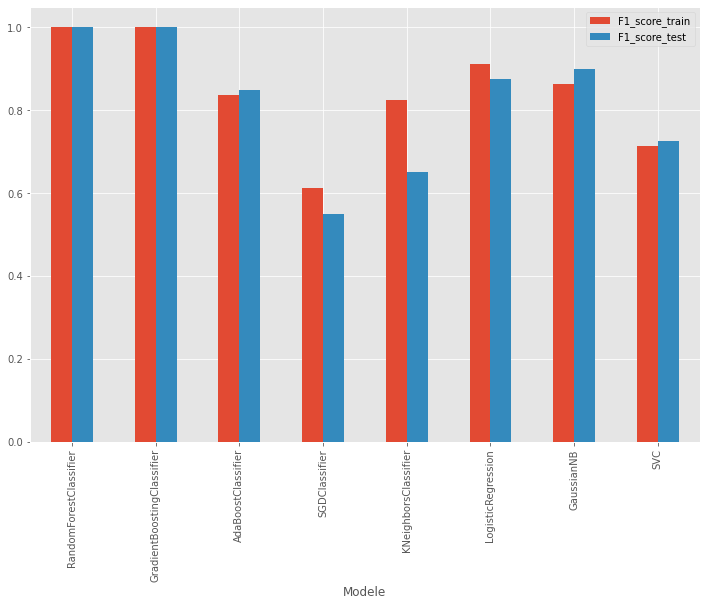

In [62]:
# Visualisation
resultat.set_index("Modele")[['F1_score_train','F1_score_test']].plot.bar()

> ## **2. Optimisation**

In [63]:
# Instanciation de notre modèle retenu
randomForest = RandomForestClassifier()

In [64]:
#Définition des hypermparamètres à optimiser
params = {
      "n_estimators" : [ 100,150, 200],
      "max_depth" : [1, 0.1, 0.01],
      "min_samples_split" : [2,3,5],
      "min_samples_leaf" : [1,2]

}

In [65]:
#Optimisation par GridSearchCV
cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
cv_randomForest = GridSearchCV(randomForest, params, scoring='f1_micro', n_jobs=-1, cv=cv).fit(X_train, y_train)

In [66]:
print(cv_randomForest.best_params_)

{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [67]:
#Entrainement du modèle final avec les meilleurs hyperparamètres
randomForest_final = RandomForestClassifier( **cv_randomForest.best_params_)
randomForest_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=1)

In [68]:
# Calcul des Predictions par rapport à nos données de test pour déterminer les scores
y_pred = randomForest_final.predict(X_test)

In [69]:
#F1_score
f1_score(y_test, y_pred, average='micro')*100

72.50000000000001

In [70]:
#Rappel
recall_score(y_test, y_pred, average='micro')*100

72.5

In [71]:
#Precision
precision_score(y_test,y_pred, average='micro')*100

72.5

In [72]:
#Rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.00      0.00      0.00         5
           2       0.50      1.00      0.67        11
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3

    accuracy                           0.73        40
   macro avg       0.30      0.40      0.33        40
weighted avg       0.59      0.72      0.63        40



In [73]:
#Proportions par rapport aux données de test
y_test.value_counts()

Drug
0       18
2       11
1        5
4        3
3        3
dtype: int64

<AxesSubplot:>

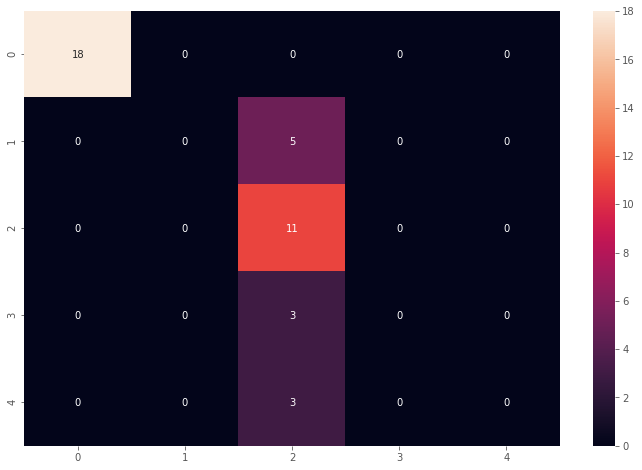

In [74]:
#Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='g')

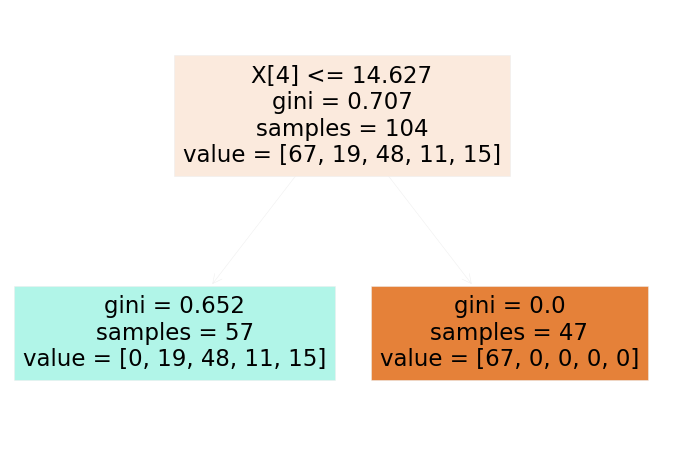

In [75]:
from sklearn.tree import plot_tree
plot_tree(randomForest_final.estimators_[0], filled=True)
plt.show()